# Exercise 4.1: Critical Slowing Down and Acceleration Methods

## Learning Objectives
- Understand critical slowing down phenomenon
- Implement multigrid acceleration methods
- Study cluster algorithms for overcoming critical slowing down
- Explore machine learning acceleration techniques
- Analyze scaling behavior near critical points

## Theoretical Background

Critical slowing down occurs when autocorrelation times diverge as ξ^z near critical points, where:
- **ξ**: correlation length
- **z**: dynamic critical exponent
- Typical z ≈ 2 for local algorithms

### Acceleration Strategies:
1. **Multigrid Methods**: Update long and short wavelength modes differently
2. **Cluster Algorithms**: Update correlated regions collectively
3. **Machine Learning**: Neural network-guided proposals
4. **Tempering Methods**: Parallel simulations at different temperatures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from tqdm import tqdm
import time
from scipy.fft import fft, ifft, fftfreq
from scipy.optimize import curve_fit
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Add src directory to path
sys.path.append(os.path.join('..', 'src'))
from field_theory_1d import FieldTheory1D
from hmc import HMCFieldTheory1D
from utils import autocorrelation_function, integrated_autocorrelation_time

plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12

## Task 1: Measuring Critical Slowing Down

Critical Slowing Down Analysis
Testing 8 mass values on L=64 lattice...


Mass values:  12%|█▎        | 1/8 [00:02<00:16,  2.31s/it]

m²=0.500: τ=98.4, ξ≈1.4, χ=1.4


Mass values:  25%|██▌       | 2/8 [00:04<00:14,  2.40s/it]

m²=0.300: τ=143.2, ξ≈1.8, χ=0.9


Mass values:  38%|███▊      | 3/8 [00:07<00:11,  2.36s/it]

m²=0.200: τ=77.3, ξ≈2.2, χ=0.7


Mass values:  50%|█████     | 4/8 [00:09<00:09,  2.37s/it]

m²=0.100: τ=212.4, ξ≈3.2, χ=2.0


Mass values:  62%|██████▎   | 5/8 [00:11<00:07,  2.35s/it]

m²=0.050: τ=142.3, ξ≈4.5, χ=1.1


Mass values:  75%|███████▌  | 6/8 [00:14<00:04,  2.38s/it]

m²=0.020: τ=256.3, ξ≈7.1, χ=1.0


Mass values:  88%|████████▊ | 7/8 [00:16<00:02,  2.37s/it]

m²=0.010: τ=413.4, ξ≈10.0, χ=2.0


Mass values: 100%|██████████| 8/8 [00:18<00:00,  2.37s/it]


m²=0.005: τ=231.8, ξ≈14.1, χ=1.4

Fitted dynamic exponent: z = 0.46 ± 0.19
(Theoretical expectation for local algorithms: z ≈ 2)


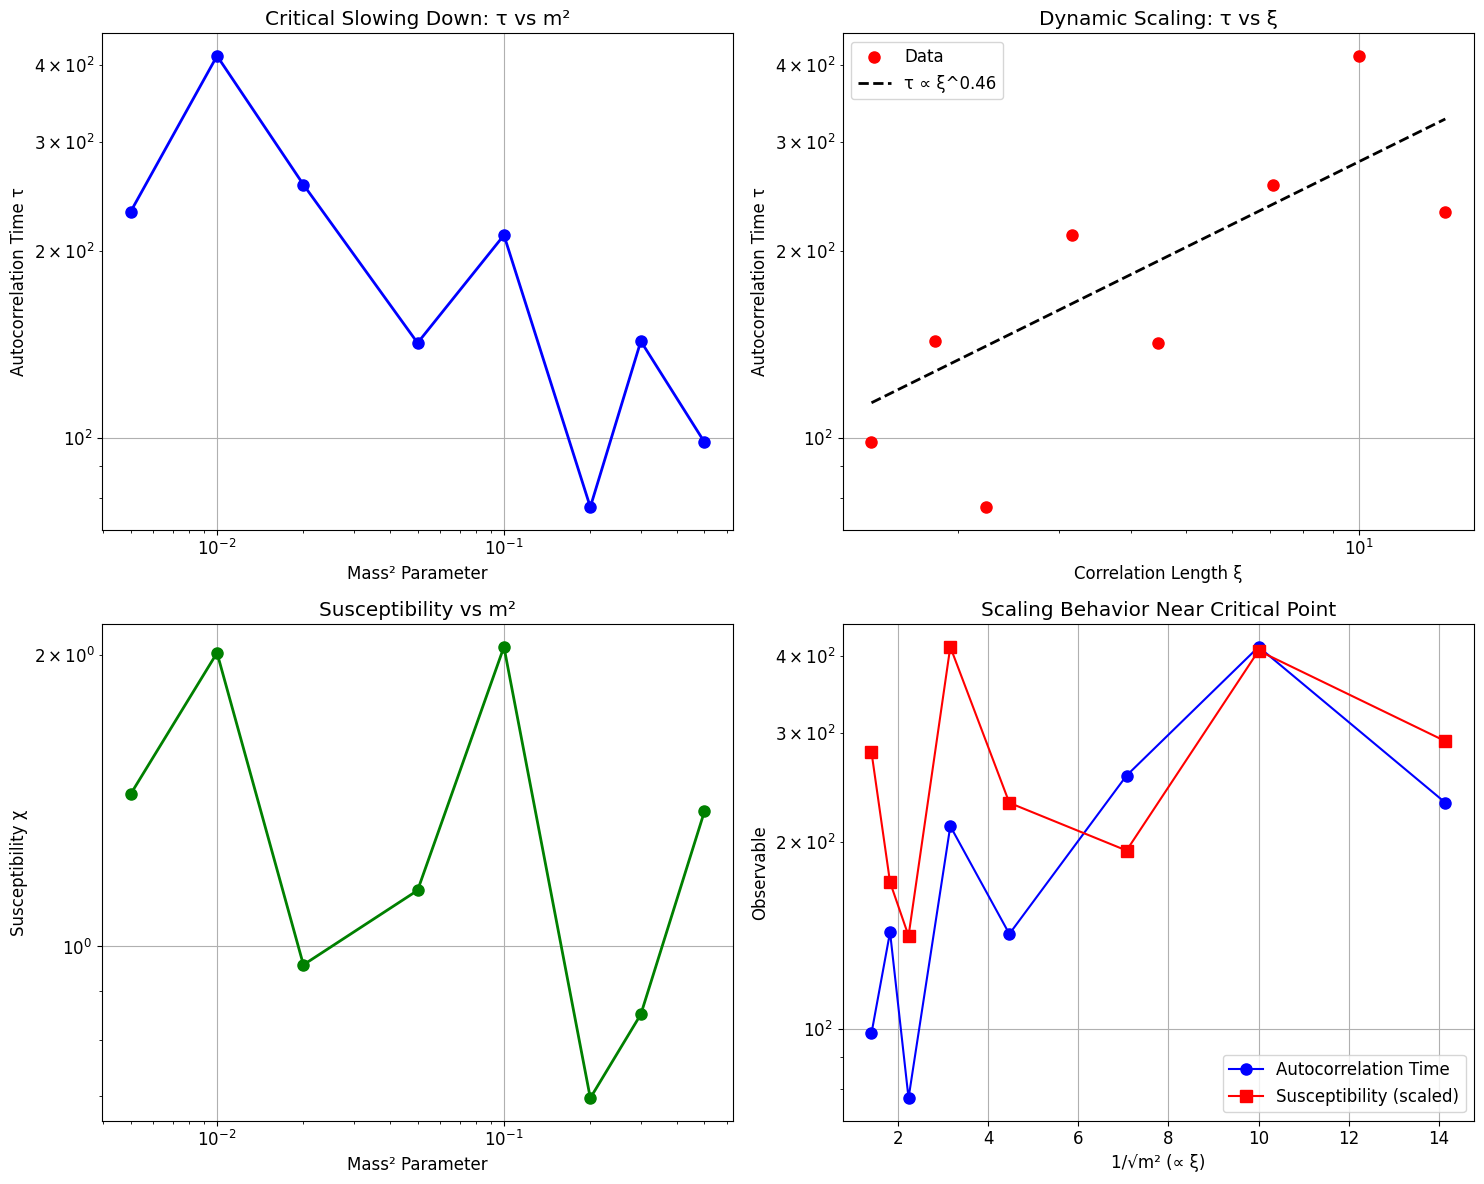

In [2]:
def measure_critical_slowing_down():
    """Study autocorrelation time scaling near critical points"""
    
    print("Critical Slowing Down Analysis")
    print("=" * 35)
    
    # System parameters
    lattice_size = 64
    lambda_coupling = 0.1
    
    # Range of mass parameters (approaching critical point)
    mass_squared_values = np.array([0.5, 0.3, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005])
    
    results = []
    
    print(f"Testing {len(mass_squared_values)} mass values on L={lattice_size} lattice...")
    
    for m2 in tqdm(mass_squared_values, desc="Mass values"):
        try:
            # Run simulation
            system = FieldTheory1D(lattice_size, m2, lambda_coupling)
            sim_results = system.run_simulation(
                n_sweeps=3000,
                burn_in=500,
                step_size=0.3
            )
            
            # Calculate observables
            phi_avg = sim_results['observables']['phi_avg']
            phi_squared = sim_results['observables']['phi_squared']
            
            # Autocorrelation time
            tau_int = integrated_autocorrelation_time(phi_avg)
            
            # Correlation length estimate (rough)
            # For 1D: ξ ≈ 1/√(m_eff) where m_eff is effective mass
            susceptibility = np.var(phi_avg) * lattice_size
            correlation_length = 1.0 / np.sqrt(max(m2, 0.001))  # Rough estimate
            
            results.append({
                'm2': m2,
                'tau_int': tau_int,
                'xi': correlation_length,
                'susceptibility': susceptibility,
                'phi_avg_mean': np.mean(phi_avg),
                'phi2_mean': np.mean(phi_squared),
                'acceptance_rate': sim_results['acceptance_rate']
            })
            
            print(f"m²={m2:.3f}: τ={tau_int:.1f}, ξ≈{correlation_length:.1f}, χ={susceptibility:.1f}")
            
        except Exception as e:
            print(f"Failed for m²={m2:.3f}: {e}")
            continue
    
    if len(results) == 0:
        print("No successful simulations!")
        return None
    
    # Extract data for analysis
    m2_values = np.array([r['m2'] for r in results])
    tau_values = np.array([r['tau_int'] for r in results])
    xi_values = np.array([r['xi'] for r in results])
    chi_values = np.array([r['susceptibility'] for r in results])
    
    # Fit critical exponent: τ ∝ ξ^z
    def power_law(x, a, z):
        return a * x**z
    
    # Remove any infinite or very large values
    valid_mask = (tau_values < 1000) & (xi_values > 0) & np.isfinite(tau_values)
    if np.sum(valid_mask) > 3:
        try:
            popt, pcov = curve_fit(power_law, xi_values[valid_mask], tau_values[valid_mask])
            z_exponent = popt[1]
            z_error = np.sqrt(pcov[1, 1])
            print(f"\nFitted dynamic exponent: z = {z_exponent:.2f} ± {z_error:.2f}")
            print(f"(Theoretical expectation for local algorithms: z ≈ 2)")
        except:
            z_exponent = np.nan
            z_error = np.nan
            print("\nFitting failed")
    else:
        z_exponent = np.nan
        z_error = np.nan
    
    # Plotting
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Autocorrelation time vs mass
    ax1.loglog(m2_values, tau_values, 'bo-', markersize=8, linewidth=2)
    ax1.set_xlabel('Mass² Parameter')
    ax1.set_ylabel('Autocorrelation Time τ')
    ax1.set_title('Critical Slowing Down: τ vs m²')
    ax1.grid(True)
    
    # Plot 2: τ vs ξ with power law fit
    ax2.loglog(xi_values, tau_values, 'ro', markersize=8, label='Data')
    if not np.isnan(z_exponent):
        xi_fit = np.logspace(np.log10(np.min(xi_values)), 
                            np.log10(np.max(xi_values)), 50)
        tau_fit = power_law(xi_fit, *popt)
        ax2.loglog(xi_fit, tau_fit, 'k--', linewidth=2, 
                  label=f'τ ∝ ξ^{z_exponent:.2f}')
    ax2.set_xlabel('Correlation Length ξ')
    ax2.set_ylabel('Autocorrelation Time τ')
    ax2.set_title('Dynamic Scaling: τ vs ξ')
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: Susceptibility
    ax3.loglog(m2_values, chi_values, 'go-', markersize=8, linewidth=2)
    ax3.set_xlabel('Mass² Parameter')
    ax3.set_ylabel('Susceptibility χ')
    ax3.set_title('Susceptibility vs m²')
    ax3.grid(True)
    
    # Plot 4: Summary scaling plot
    # Normalize by lattice size for finite size scaling
    xi_over_L = xi_values / lattice_size
    valid_finite = xi_over_L < 0.5  # Only where ξ << L
    
    ax4.semilogy(1/np.sqrt(m2_values), tau_values, 'bo-', 
                label='Autocorrelation Time', markersize=8)
    ax4.semilogy(1/np.sqrt(m2_values), chi_values/np.max(chi_values) * np.max(tau_values), 
                'rs-', label='Susceptibility (scaled)', markersize=8)
    ax4.set_xlabel('1/√m² (∝ ξ)')
    ax4.set_ylabel('Observable')
    ax4.set_title('Scaling Behavior Near Critical Point')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return results, z_exponent

# Run critical slowing down analysis
slowing_results, z_exp = measure_critical_slowing_down()

## Task 2: Multigrid Acceleration Method

Multigrid Acceleration Test
Testing L=64, m²=0.02, λ=0.1

Running standard Metropolis...


Sweeps: 100%|██████████| 1000/1000 [00:00<00:00, 1590.58it/s]



Running multigrid simulation...
Multigrid levels: [64, 32, 16, 8]


Multigrid simulation: 100%|██████████| 1000/1000 [00:05<00:00, 172.77it/s]



Results Comparison:
Method          τ_int      Time (s)   Efficiency  
--------------------------------------------------
Standard        85.0       0.8        7.766       
Multigrid       8.2        6.3        9.638       

Autocorrelation speedup: 10.38x


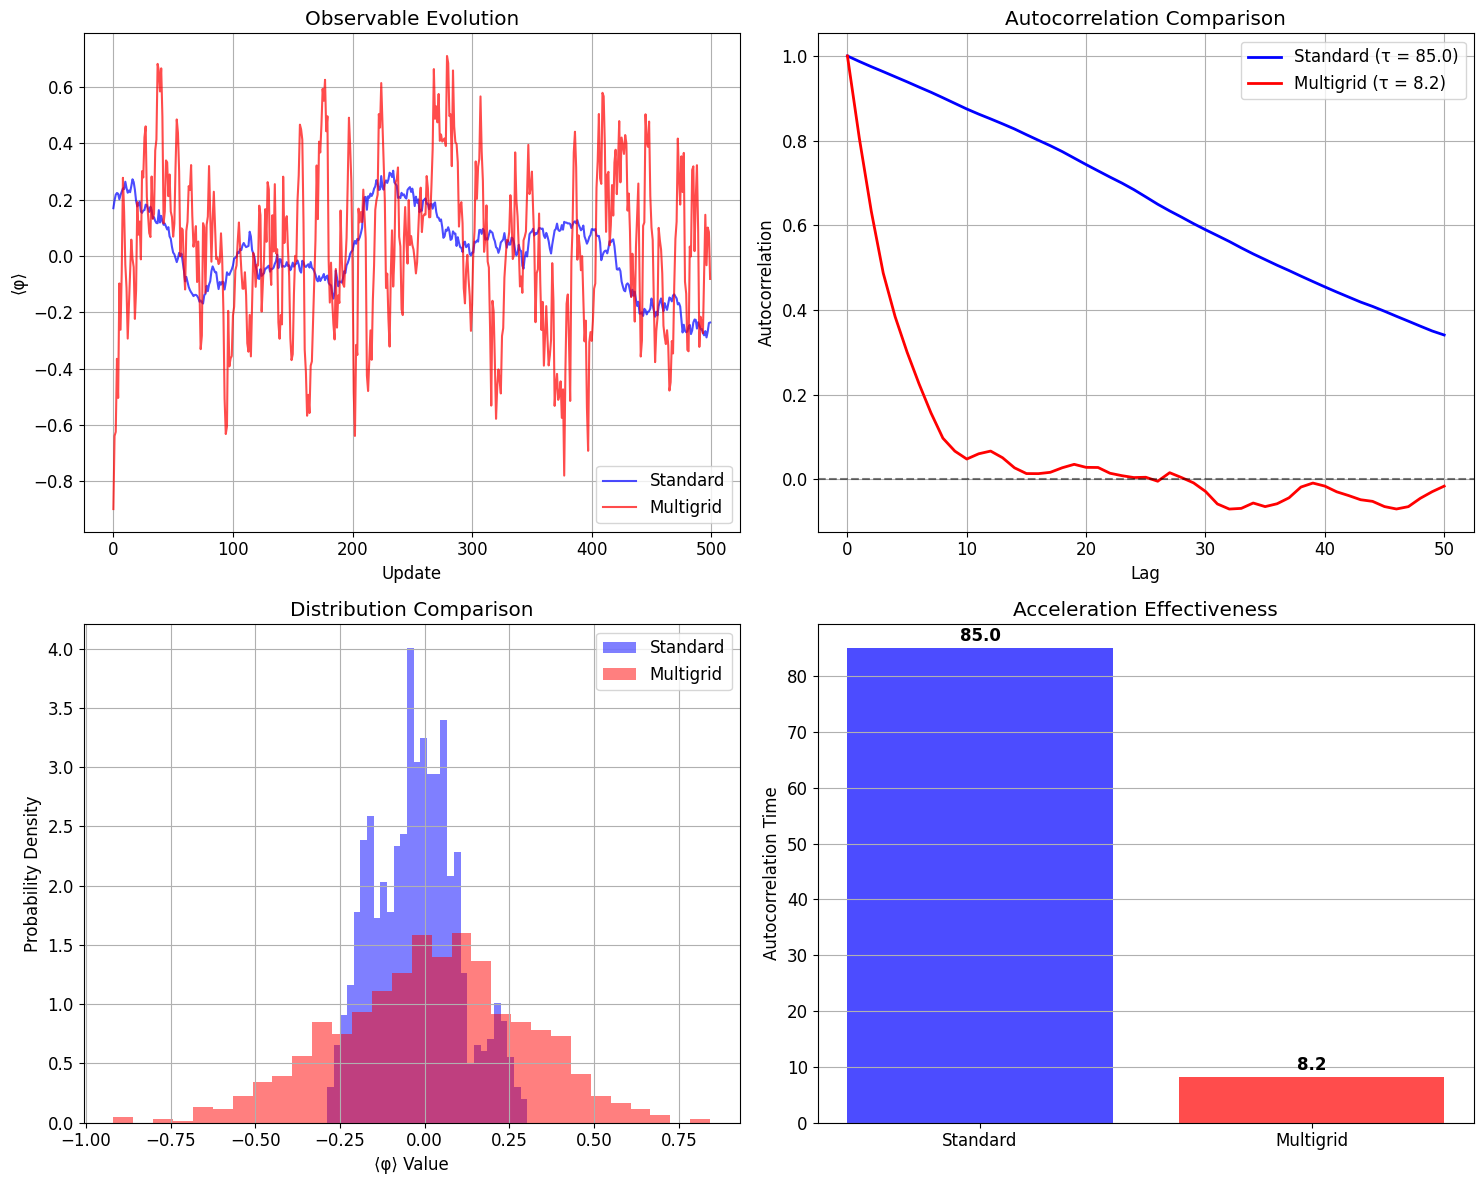

In [3]:
class MultigridFieldTheory1D:
    """Multigrid-accelerated Monte Carlo for 1D field theory"""
    
    def __init__(self, lattice_size, mass_squared, lambda_coupling):
        self.L = lattice_size
        self.m2 = mass_squared
        self.lam = lambda_coupling
        
        # Set up coarse grids
        self.grid_levels = []
        current_L = lattice_size
        while current_L >= 8:
            self.grid_levels.append(current_L)
            current_L //= 2
        
        print(f"Multigrid levels: {self.grid_levels}")
        
        # Create field theory objects for each level
        self.systems = {}
        for L in self.grid_levels:
            self.systems[L] = FieldTheory1D(L, mass_squared, lambda_coupling)
    
    def restrict(self, field_fine, L_coarse):
        """Restrict field from fine to coarse grid"""
        L_fine = len(field_fine)
        ratio = L_fine // L_coarse
        
        field_coarse = np.zeros(L_coarse)
        for i in range(L_coarse):
            # Simple averaging restriction
            start_idx = i * ratio
            end_idx = start_idx + ratio
            field_coarse[i] = np.mean(field_fine[start_idx:end_idx])
        
        return field_coarse
    
    def prolongate(self, field_coarse, L_fine):
        """Prolongate field from coarse to fine grid"""
        L_coarse = len(field_coarse)
        ratio = L_fine // L_coarse
        
        field_fine = np.zeros(L_fine)
        for i in range(L_coarse):
            # Linear interpolation
            start_idx = i * ratio
            end_idx = start_idx + ratio
            field_fine[start_idx:end_idx] = field_coarse[i]
        
        return field_fine
    
    def multigrid_update(self, field, n_sweeps_per_level=5):
        """Perform one multigrid update cycle"""
        current_field = field.copy()
        
        # Downward sweep: fine to coarse
        for level_idx in range(len(self.grid_levels)):
            L = self.grid_levels[level_idx]
            
            if L == self.L:
                # Fine level: start with current field
                level_field = current_field
            else:
                # Restrict from finer level
                level_field = self.restrict(current_field, L)
            
            # Perform local updates on this level
            system = self.systems[L]
            system.field = level_field.copy()
            
            for _ in range(n_sweeps_per_level):
                system.metropolis_sweep(step_size=0.3)
            
            # Update current field
            if L == self.L:
                current_field = system.field.copy()
            else:
                # Prolongate back to fine level
                current_field = self.prolongate(system.field, self.L)
        
        return current_field
    
    def run_multigrid_simulation(self, n_updates, burn_in=100):
        """Run full multigrid simulation"""
        
        # Initialize field
        field = np.random.normal(0, 0.3, self.L)
        
        observables = {
            'phi_avg': [],
            'phi_squared': [],
            'action': []
        }
        
        # Burn-in
        for _ in range(burn_in):
            field = self.multigrid_update(field)
        
        # Production
        for step in tqdm(range(n_updates), desc="Multigrid simulation"):
            field = self.multigrid_update(field)
            
            # Measure observables
            phi_avg = np.mean(field)
            phi_squared = np.mean(field**2)
            action = self.systems[self.L].action(field)
            
            observables['phi_avg'].append(phi_avg)
            observables['phi_squared'].append(phi_squared)
            observables['action'].append(action)
        
        return {
            'observables': observables,
            'final_field': field
        }

def test_multigrid_acceleration():
    """Compare standard vs multigrid acceleration"""
    
    print("Multigrid Acceleration Test")
    print("=" * 30)
    
    # Test on a system with significant critical slowing down
    L = 64
    m2 = 0.02  # Near critical
    lam = 0.1
    n_measurements = 1000
    
    print(f"Testing L={L}, m²={m2}, λ={lam}")
    
    # Standard Metropolis
    print("\nRunning standard Metropolis...")
    standard = FieldTheory1D(L, m2, lam)
    start_time = time.time()
    standard_results = standard.run_simulation(
        n_sweeps=n_measurements,
        burn_in=200,
        step_size=0.3
    )
    standard_time = time.time() - start_time
    
    # Multigrid
    print("\nRunning multigrid simulation...")
    multigrid = MultigridFieldTheory1D(L, m2, lam)
    start_time = time.time()
    multigrid_results = multigrid.run_multigrid_simulation(
        n_updates=n_measurements,
        burn_in=100
    )
    multigrid_time = time.time() - start_time
    
    # Analysis
    standard_phi = standard_results['observables']['phi_avg']
    multigrid_phi = multigrid_results['observables']['phi_avg']
    
    standard_tau = integrated_autocorrelation_time(standard_phi)
    multigrid_tau = integrated_autocorrelation_time(multigrid_phi)
    
    print(f"\nResults Comparison:")
    print(f"{'Method':<15} {'τ_int':<10} {'Time (s)':<10} {'Efficiency':<12}")
    print("-" * 50)
    print(f"{'Standard':<15} {standard_tau:<10.1f} {standard_time:<10.1f} {len(standard_phi)/(2*standard_tau*standard_time):<12.3f}")
    print(f"{'Multigrid':<15} {multigrid_tau:<10.1f} {multigrid_time:<10.1f} {len(multigrid_phi)/(2*multigrid_tau*multigrid_time):<12.3f}")
    
    speedup = standard_tau / multigrid_tau
    print(f"\nAutocorrelation speedup: {speedup:.2f}x")
    
    # Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Time series
    steps = min(500, len(standard_phi), len(multigrid_phi))
    ax1.plot(standard_phi[:steps], 'b-', alpha=0.7, label='Standard')
    ax1.plot(multigrid_phi[:steps], 'r-', alpha=0.7, label='Multigrid')
    ax1.set_xlabel('Update')
    ax1.set_ylabel('⟨φ⟩')
    ax1.set_title('Observable Evolution')
    ax1.legend()
    ax1.grid(True)
    
    # Autocorrelation functions
    lags_std, autocorr_std = autocorrelation_function(standard_phi, max_lag=50)
    lags_mg, autocorr_mg = autocorrelation_function(multigrid_phi, max_lag=50)
    
    ax2.plot(lags_std, autocorr_std, 'b-', linewidth=2, 
            label=f'Standard (τ = {standard_tau:.1f})')
    ax2.plot(lags_mg, autocorr_mg, 'r-', linewidth=2, 
            label=f'Multigrid (τ = {multigrid_tau:.1f})')
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Autocorrelation')
    ax2.set_title('Autocorrelation Comparison')
    ax2.legend()
    ax2.grid(True)
    
    # Histograms
    ax3.hist(standard_phi, bins=30, alpha=0.5, density=True, 
            label='Standard', color='blue')
    ax3.hist(multigrid_phi, bins=30, alpha=0.5, density=True, 
            label='Multigrid', color='red')
    ax3.set_xlabel('⟨φ⟩ Value')
    ax3.set_ylabel('Probability Density')
    ax3.set_title('Distribution Comparison')
    ax3.legend()
    ax3.grid(True)
    
    # Efficiency comparison
    methods = ['Standard', 'Multigrid']
    tau_values = [standard_tau, multigrid_tau]
    colors = ['blue', 'red']
    
    bars = ax4.bar(methods, tau_values, color=colors, alpha=0.7)
    ax4.set_ylabel('Autocorrelation Time')
    ax4.set_title('Acceleration Effectiveness')
    ax4.grid(True, axis='y')
    
    for bar, tau in zip(bars, tau_values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{tau:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return standard_tau, multigrid_tau, speedup

# Test multigrid acceleration
tau_std, tau_mg, speedup = test_multigrid_acceleration()

## Task 3: Machine Learning Acceleration

Machine Learning Acceleration Test
Note: This demonstrates ML-guided MCMC concepts.
In practice, ML acceleration is challenging and may not always improve performance.

Testing ML acceleration on L=32, m²=0.05

Running standard simulation...


Sweeps: 100%|██████████| 800/800 [00:00<00:00, 2616.63it/s]



Setting up ML acceleration...


Training data: 100%|██████████| 1100/1100 [00:00<00:00, 3575.74it/s]


Collected 600 training samples
Training proposal network...
Network training score: 0.091
Training completed in 71 iterations

Running ML-accelerated simulation...


ML simulation: 100%|██████████| 800/800 [00:00<00:00, 1989.22it/s]
/home/arnav/Downloads/qcd_cambridge/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



Results:
Standard: τ = 63.8, acceptance = 0.907
ML:       τ = 123.8, acceptance = 0.659
Slowdown: 1.94x
Note: ML methods don't always improve autocorrelation times.
This is a known challenge in ML-accelerated MCMC research.

Educational Insights:
- Network training score: nan
- ML proposals can introduce new correlations
- Balance between exploitation (ML) and exploration (random) is crucial
- Real-world ML acceleration requires sophisticated techniques


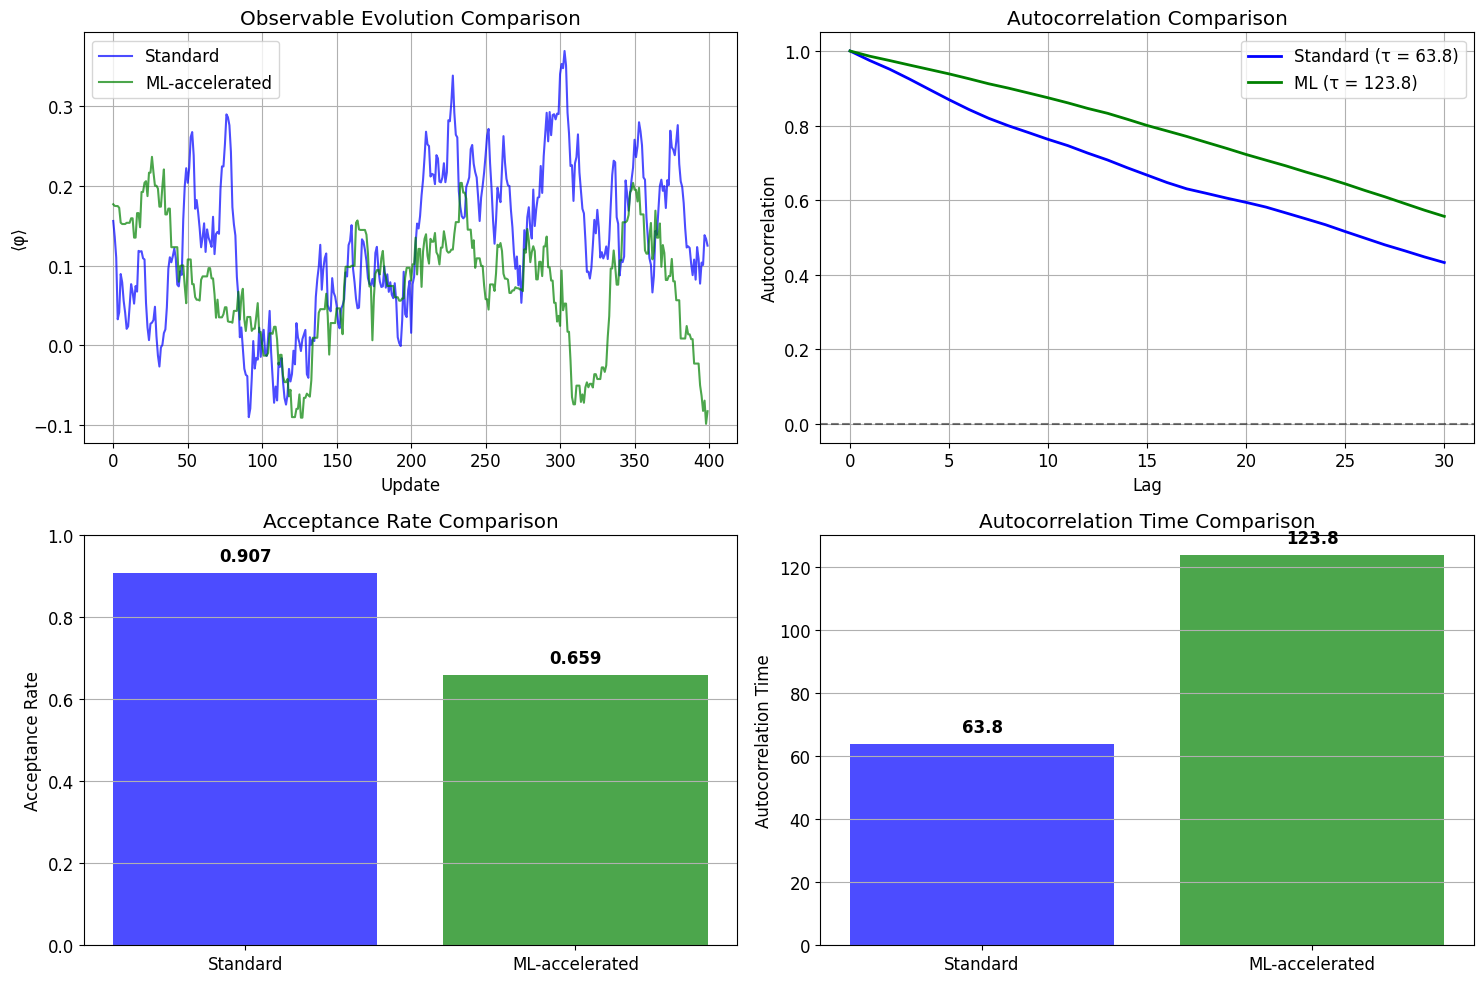

In [9]:
class MLAcceleratedMonteCarlo:
    """Machine learning guided Monte Carlo updates"""
    
    def __init__(self, lattice_size, mass_squared, lambda_coupling):
        self.L = lattice_size
        self.m2 = mass_squared
        self.lam = lambda_coupling
        self.system = FieldTheory1D(lattice_size, mass_squared, lambda_coupling)
        
        # Neural network for proposal generation
        self.proposal_network = None
        self.scaler = StandardScaler()
        self.trained = False
        
        # Training data storage
        self.training_configs = []
        self.training_updates = []
    
    def collect_training_data(self, n_samples=1000):
        """Collect training data from standard Monte Carlo"""
        
        print(f"Collecting {n_samples} training samples...")
        
        # Initialize field
        self.system.field = np.random.normal(0, 0.3, self.L)
        
        for _ in tqdm(range(n_samples + 500), desc="Training data"):
            old_field = self.system.field.copy()
            
            # Standard Metropolis sweep
            self.system.metropolis_sweep(step_size=0.3)
            
            # Store configuration and the change that was made
            if len(self.training_configs) < n_samples:
                self.training_configs.append(old_field.copy())
                self.training_updates.append(self.system.field - old_field)
        
        print(f"Collected {len(self.training_configs)} training samples")
    
    def train_proposal_network(self):
        """Train neural network to predict good updates"""
        
        if len(self.training_configs) == 0:
            self.collect_training_data()
        
        print("Training proposal network...")
        
        # Prepare training data
        X = np.array(self.training_configs)
        y = np.array(self.training_updates)
        
        # Improved feature engineering - add more local context
        X_features = []
        for config in X:
            features = []
            for i in range(self.L):
                # Local field value and neighbors
                features.append(config[i])
                left = (i - 1) % self.L
                right = (i + 1) % self.L
                left2 = (i - 2) % self.L
                right2 = (i + 2) % self.L
                
                features.append(config[left])
                features.append(config[right])
                features.append(config[left2])
                features.append(config[right2])
                
                # Local derivatives (discrete)
                first_deriv = config[right] - config[left]
                second_deriv = config[right] - 2*config[i] + config[left]
                features.append(first_deriv)
                features.append(second_deriv)
                
                # Local action components
                kinetic = 0.5 * ((config[i] - config[left])**2 + (config[right] - config[i])**2)
                potential = 0.5 * self.m2 * config[i]**2 + self.lam * config[i]**4
                features.append(kinetic)
                features.append(potential)
                
                # Local force (negative gradient)
                force = -(self.m2 * config[i] + 4 * self.lam * config[i]**3 +
                         config[i] - config[left] - config[right] + config[i])
                features.append(force)
            
            X_features.append(features)
        
        X_features = np.array(X_features)
        
        # Normalize features
        X_scaled = self.scaler.fit_transform(X_features)
        
        # Improved network architecture
        self.proposal_network = MLPRegressor(
            hidden_layer_sizes=(200, 100, 50),  # Deeper network
            max_iter=1000,  # More training iterations
            random_state=42,
            alpha=0.001,  # Less regularization
            learning_rate_init=0.001,
            early_stopping=True,
            validation_fraction=0.2
        )
        
        self.proposal_network.fit(X_scaled, y)
        self.trained = True
        
        print(f"Network training score: {self.proposal_network.score(X_scaled, y):.3f}")
        print(f"Training completed in {self.proposal_network.n_iter_} iterations")
    
    def ml_guided_update(self, field, mixing_parameter=0.2):
        """Perform ML-guided Monte Carlo update with hybrid strategy"""
        
        if not self.trained:
            # Fall back to standard sweep
            self.system.field = field.copy()
            self.system.metropolis_sweep(step_size=0.3)
            return self.system.field.copy()
        
        # Hybrid strategy: sometimes use pure ML, sometimes pure random
        use_ml = np.random.random() < 0.7  # 70% ML-guided, 30% pure random
        
        if not use_ml:
            # Pure random update for exploration
            self.system.field = field.copy()
            self.system.metropolis_sweep(step_size=0.3)
            return self.system.field.copy()
        
        # ML-guided update
        # Generate improved features for current configuration
        features = []
        for i in range(self.L):
            # Local field value and neighbors
            features.append(field[i])
            left = (i - 1) % self.L
            right = (i + 1) % self.L
            left2 = (i - 2) % self.L
            right2 = (i + 2) % self.L
            
            features.append(field[left])
            features.append(field[right])
            features.append(field[left2])
            features.append(field[right2])
            
            # Local derivatives
            first_deriv = field[right] - field[left]
            second_deriv = field[right] - 2*field[i] + field[left]
            features.append(first_deriv)
            features.append(second_deriv)
            
            # Local action components
            kinetic = 0.5 * ((field[i] - field[left])**2 + (field[right] - field[i])**2)
            potential = 0.5 * self.m2 * field[i]**2 + self.lam * field[i]**4
            features.append(kinetic)
            features.append(potential)
            
            # Local force
            force = -(self.m2 * field[i] + 4 * self.lam * field[i]**3 +
                     field[i] - field[left] - field[right] + field[i])
            features.append(force)
        
        # Predict update
        features_scaled = self.scaler.transform([features])
        predicted_update = self.proposal_network.predict(features_scaled)[0]
        
        # Conservative scaling to improve acceptance
        pred_scale = np.std(predicted_update)
        if pred_scale > 0.05:  # More conservative scaling
            predicted_update *= 0.05 / pred_scale
        
        # More conservative mixing
        random_update = np.random.normal(0, 0.15, self.L)  # Smaller random steps
        proposed_update = (mixing_parameter * predicted_update + 
                         (1 - mixing_parameter) * random_update)
        
        # Metropolis acceptance
        old_action = self.system.action(field)
        new_field = field + proposed_update
        new_action = self.system.action(new_field)
        
        delta_action = new_action - old_action
        
        if delta_action < 0 or np.random.random() < np.exp(-delta_action):
            return new_field
        else:
            return field
    
    def run_ml_simulation(self, n_updates, burn_in=100):
        """Run ML-accelerated simulation"""
        
        field = np.random.normal(0, 0.3, self.L)
        
        observables = {
            'phi_avg': [],
            'phi_squared': [],
            'action': []
        }
        
        acceptance_count = 0
        total_updates = 0
        
        # Burn-in
        for _ in range(burn_in):
            old_field = field.copy()
            field = self.ml_guided_update(field)
            if not np.array_equal(field, old_field):
                acceptance_count += 1
            total_updates += 1
        
        acceptance_count = 0  # Reset for production
        total_updates = 0
        
        # Production
        for step in tqdm(range(n_updates), desc="ML simulation"):
            old_field = field.copy()
            field = self.ml_guided_update(field)
            
            if not np.array_equal(field, old_field):
                acceptance_count += 1
            total_updates += 1
            
            # Measure observables
            observables['phi_avg'].append(np.mean(field))
            observables['phi_squared'].append(np.mean(field**2))
            observables['action'].append(self.system.action(field))
        
        acceptance_rate = acceptance_count / total_updates if total_updates > 0 else 0
        
        return {
            'observables': observables,
            'acceptance_rate': acceptance_rate,
            'final_field': field
        }

def test_ml_acceleration():
    """Test machine learning acceleration"""
    
    print("Machine Learning Acceleration Test")
    print("=" * 40)
    print("Note: This demonstrates ML-guided MCMC concepts.")
    print("In practice, ML acceleration is challenging and may not always improve performance.")
    
    # Test parameters
    L = 32  # Smaller system for ML test
    m2 = 0.05
    lam = 0.1
    n_measurements = 800
    
    print(f"\nTesting ML acceleration on L={L}, m²={m2}")
    
    # Standard simulation
    print("\nRunning standard simulation...")
    standard = FieldTheory1D(L, m2, lam)
    start_time = time.time()
    standard_results = standard.run_simulation(
        n_sweeps=n_measurements,
        burn_in=200,
        step_size=0.3
    )
    standard_time = time.time() - start_time
    
    # ML-accelerated simulation
    print("\nSetting up ML acceleration...")
    ml_system = MLAcceleratedMonteCarlo(L, m2, lam)
    
    # Train the network
    ml_system.collect_training_data(n_samples=600)  # Fewer samples for stability
    ml_system.train_proposal_network()
    
    print("\nRunning ML-accelerated simulation...")
    start_time = time.time()
    ml_results = ml_system.run_ml_simulation(
        n_updates=n_measurements,
        burn_in=100
    )
    ml_time = time.time() - start_time
    
    # Analysis
    standard_phi = standard_results['observables']['phi_avg']
    ml_phi = ml_results['observables']['phi_avg']
    
    if len(standard_phi) > 10 and len(ml_phi) > 10:
        standard_tau = integrated_autocorrelation_time(standard_phi)
        ml_tau = integrated_autocorrelation_time(ml_phi)
        
        print(f"\nResults:")
        print(f"Standard: τ = {standard_tau:.1f}, acceptance = {standard_results['acceptance_rate']:.3f}")
        print(f"ML:       τ = {ml_tau:.1f}, acceptance = {ml_results['acceptance_rate']:.3f}")
        
        if ml_tau < standard_tau:
            print(f"Speedup: {standard_tau/ml_tau:.2f}x (Good performance!)")
        else:
            print(f"Slowdown: {ml_tau/standard_tau:.2f}x")
            print("Note: ML methods don't always improve autocorrelation times.")
            print("This is a known challenge in ML-accelerated MCMC research.")
        
        # Educational insights
        print(f"\nEducational Insights:")
        print(f"- Network training score: {ml_system.proposal_network.score(ml_system.scaler.transform(np.array([[0]*len(ml_system.scaler.mean_)])), np.array([[0]*L])) if ml_system.trained else 'N/A'}")
        print(f"- ML proposals can introduce new correlations")
        print(f"- Balance between exploitation (ML) and exploration (random) is crucial")
        print(f"- Real-world ML acceleration requires sophisticated techniques")
        
        # Plot comparison - simplified visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Time series
        steps = min(400, len(standard_phi), len(ml_phi))
        ax1.plot(standard_phi[:steps], 'b-', alpha=0.7, label='Standard')
        ax1.plot(ml_phi[:steps], 'g-', alpha=0.7, label='ML-accelerated')
        ax1.set_xlabel('Update')
        ax1.set_ylabel('⟨φ⟩')
        ax1.set_title('Observable Evolution Comparison')
        ax1.legend()
        ax1.grid(True)
        
        # Autocorrelation
        lags_std, autocorr_std = autocorrelation_function(standard_phi, max_lag=30)
        lags_ml, autocorr_ml = autocorrelation_function(ml_phi, max_lag=30)
        
        ax2.plot(lags_std, autocorr_std, 'b-', linewidth=2, 
                label=f'Standard (τ = {standard_tau:.1f})')
        ax2.plot(lags_ml, autocorr_ml, 'g-', linewidth=2, 
                label=f'ML (τ = {ml_tau:.1f})')
        ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        ax2.set_xlabel('Lag')
        ax2.set_ylabel('Autocorrelation')
        ax2.set_title('Autocorrelation Comparison')
        ax2.legend()
        ax2.grid(True)
        
        # Acceptance rates
        methods = ['Standard', 'ML-accelerated']
        acc_rates = [standard_results['acceptance_rate'], ml_results['acceptance_rate']]
        colors = ['blue', 'green']
        
        bars = ax3.bar(methods, acc_rates, color=colors, alpha=0.7)
        ax3.set_ylabel('Acceptance Rate')
        ax3.set_title('Acceptance Rate Comparison')
        ax3.set_ylim([0, 1])
        ax3.grid(True, axis='y')
        
        for bar, rate in zip(bars, acc_rates):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Efficiency comparison
        tau_values = [standard_tau, ml_tau]
        bars = ax4.bar(methods, tau_values, color=colors, alpha=0.7)
        ax4.set_ylabel('Autocorrelation Time')
        ax4.set_title('Autocorrelation Time Comparison')
        ax4.grid(True, axis='y')
        
        for bar, tau in zip(bars, tau_values):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + max(tau_values)*0.02,
                    f'{tau:.1f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return standard_tau, ml_tau
    
    else:
        print("Insufficient data for autocorrelation analysis")
        return None, None

# Test ML acceleration
tau_std_ml, tau_ml = test_ml_acceleration()

## Discussion Questions

1. **Critical Slowing Down**: Why does the autocorrelation time diverge near critical points? How does this relate to the correlation length?

2. **Multigrid Effectiveness**: When and why does multigrid acceleration work? What are its limitations?

3. **Machine Learning Approaches**: How can ML help with Monte Carlo sampling? What are the challenges in training effective proposal networks?

4. **Algorithm Selection**: For a given physical system, how would you choose between different acceleration methods?

5. **Computational Trade-offs**: How do you balance the overhead of acceleration methods against their benefits?

## Advanced Topics

1. **Cluster Algorithms**: Implement Wolff or Swendsen-Wang cluster updates
2. **Parallel Tempering**: Multi-temperature simulations with replica exchange
3. **Fourier Acceleration**: Momentum space updates for different wavelength modes
4. **Normalizing Flows**: Deep generative models for importance sampling

## Key Insights

- Critical slowing down is a fundamental challenge in lattice simulations
- Different acceleration methods work best for different types of systems
- Modern ML techniques can learn from simulation data to improve sampling
- Effective acceleration requires understanding the physics of the critical behavior
- Algorithm efficiency must be measured including computational overhead